In [1]:
#Importing the required libraries
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing the dataset
seeds_df = pd. read_csv("seeds_dataset.csv", header = None)

In [3]:
#Viewing the dataset
seeds_df.head()

,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [4]:
seeds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       210 non-null    float64
 1   1       210 non-null    float64
 2   2       210 non-null    float64
 3   3       210 non-null    float64
 4   4       210 non-null    float64
 5   5       210 non-null    float64
 6   6       210 non-null    float64
 7   7       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


In [5]:
seeds_df.describe()

,0,1,2,3,4,5,6,7
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


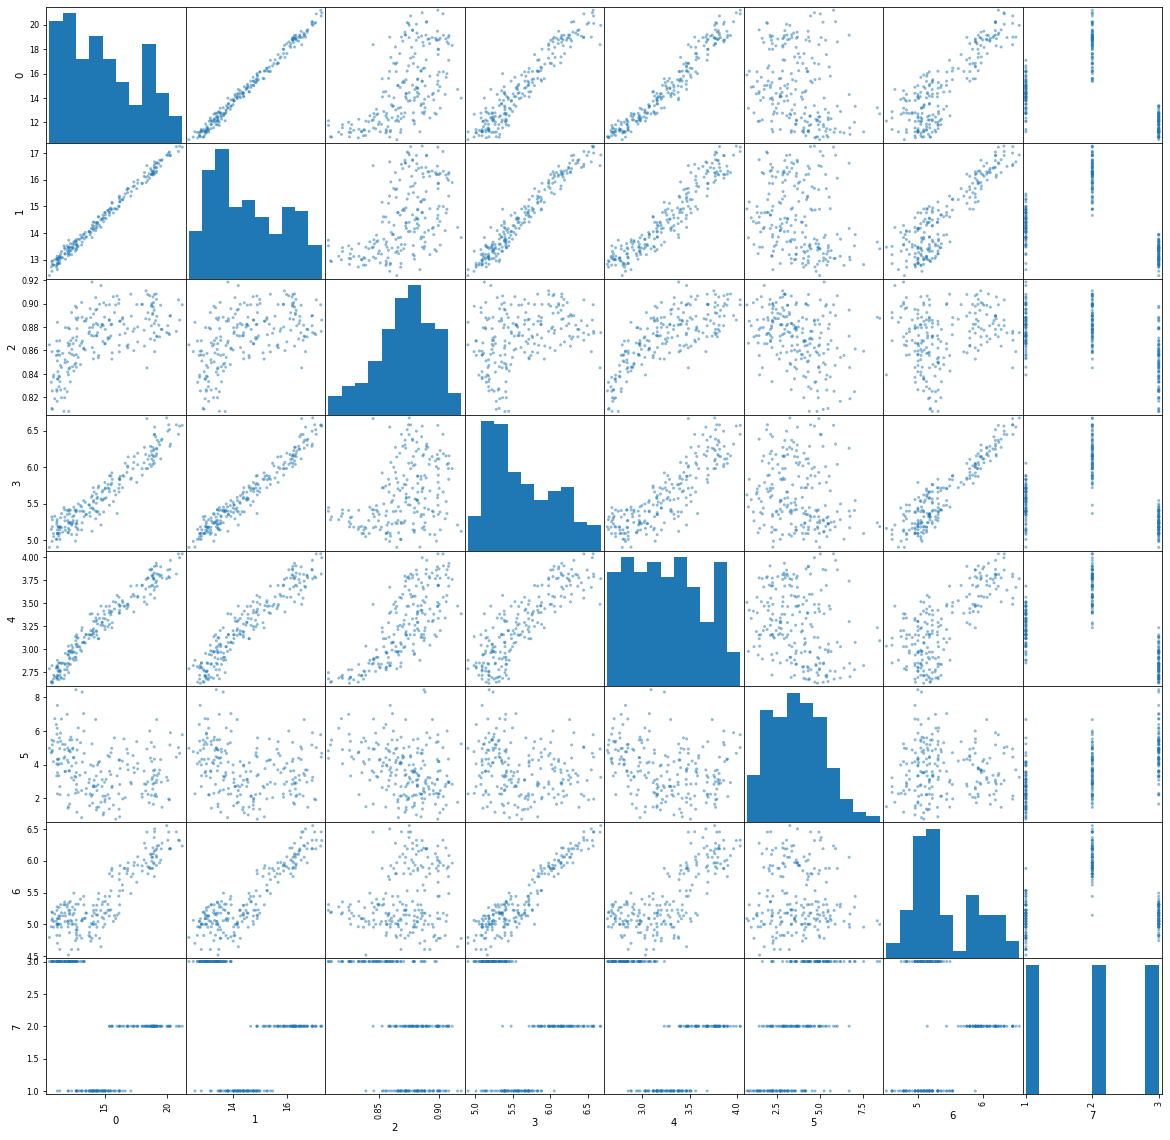

In [6]:
#Plotting the scatter plot of the dataset
from pandas.plotting import scatter_matrix

scatter_matrix(seeds_df, alpha=0.5, figsize=(20, 20))
plt.show()

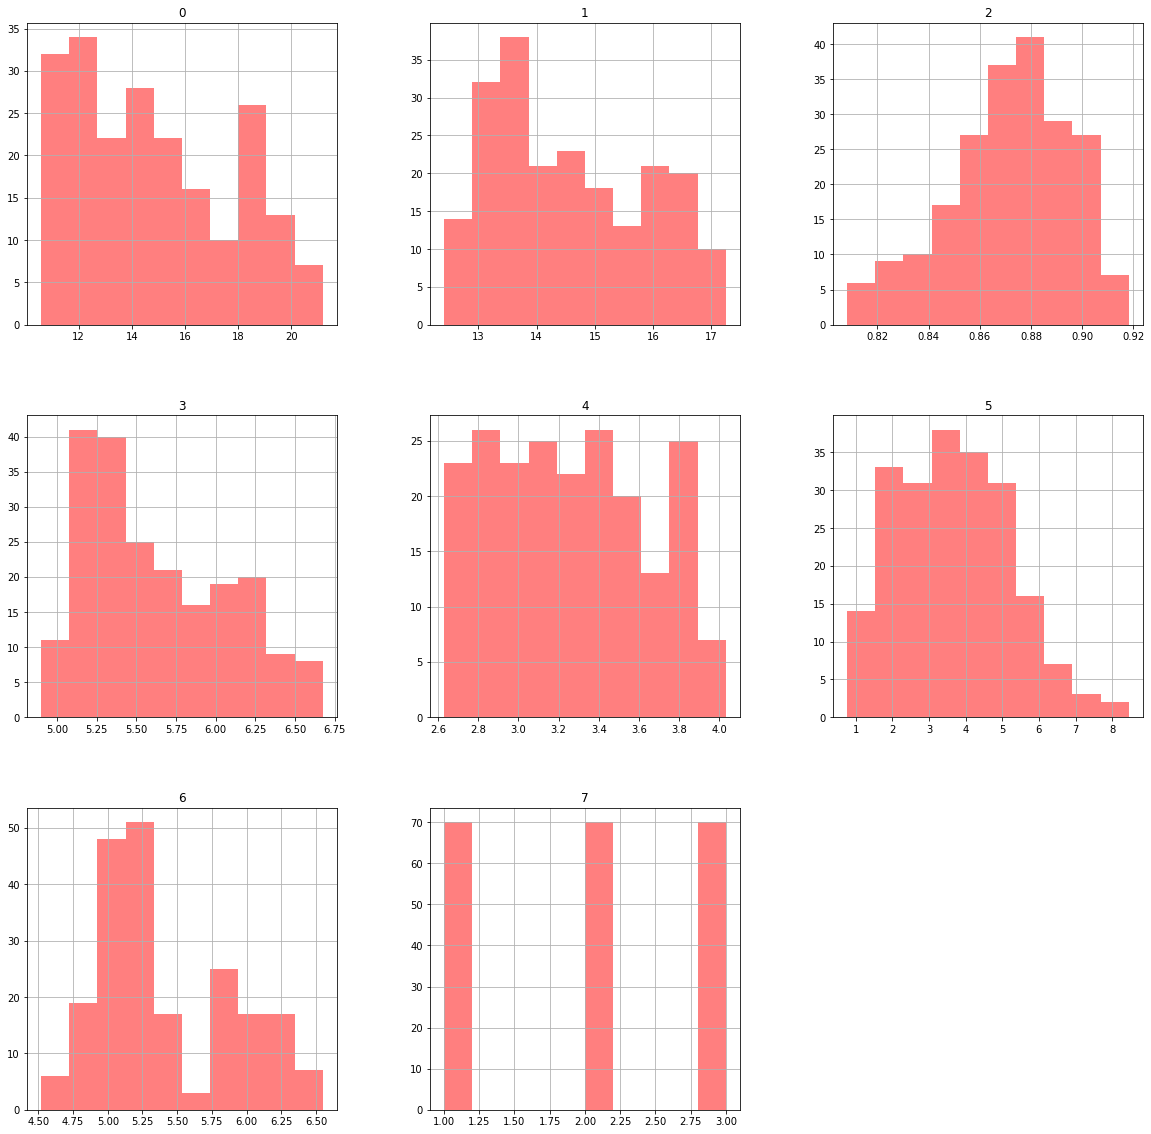

In [7]:
#Plotting the histogram of the dataset
seeds_df.hist(alpha=0.5, figsize=(20, 20), color='red')
plt.show()

In [8]:
#Loading the CSV file
def load_csv(filename):
    seeds_df = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            seeds_df.append(row)
    return seeds_df
 
#Converting string column to float
def str_column_to_float(seeds_df, column):
    for row in seeds_df:
        row[column] = float(row[column].strip())
        
#Converting string column to integer
def str_column_to_int(seeds_df, column):
    class_values = [row[column] for row in seeds_df]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in seeds_df:
        row[column] = lookup[row[column]]
    return lookup

#Finding the min and max values for each column
def dataset_minmax(seeds_df):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*seeds_df)]
    return stats
 
#Rescaling the dataset columns to the range 0-1
def normalize_dataset(seeds_df, minmax):
    for row in seeds_df:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [9]:
#Calculating neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

#Transfering neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

#Forward propagation of input to a network output
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [10]:
#Calculating the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

#Backpropagation of error and storing in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [11]:
#Updating network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']
            
#Training the network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))            

In [12]:
#Initializing the network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

In [13]:
#Making the prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

#Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

In [14]:
#Spliting the dataset into k folds
def cross_validation_split(seeds_df, n_folds):
    seeds_df_split = list()
    seeds_df_copy = list(seeds_df)
    fold_size = int(len(seeds_df) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(seeds_df_copy))
            fold.append(seeds_df_copy.pop(index))
        seeds_df_split.append(fold)
    return seeds_df_split

#Calculating accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

#Evaluate the algorithm using cross validation split
def evaluate_algorithm(seeds_df, algorithm, n_folds, *args):
    folds = cross_validation_split(seeds_df, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [15]:
#Test Backprop on Seeds dataset
seed(1)

#load and prepare data
filename = 'seeds_dataset.csv'
seeds_df = load_csv(filename)

for i in range(len(seeds_df[0])-1):
    str_column_to_float(seeds_df, i)

#convert class column to integers
str_column_to_int(seeds_df, len(seeds_df[0])-1)

#normalize input variables
minmax = dataset_minmax(seeds_df)
normalize_dataset(seeds_df, minmax)

#evaluate algorithm
n_folds = 5
l_rate = 0.3
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(seeds_df, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.300, error=134.472
>epoch=1, lrate=0.300, error=111.621
>epoch=2, lrate=0.300, error=105.319
>epoch=3, lrate=0.300, error=94.644
>epoch=4, lrate=0.300, error=82.104
>epoch=5, lrate=0.300, error=72.356
>epoch=6, lrate=0.300, error=65.839
>epoch=7, lrate=0.300, error=61.001
>epoch=8, lrate=0.300, error=56.748
>epoch=9, lrate=0.300, error=52.588
>epoch=10, lrate=0.300, error=48.424
>epoch=11, lrate=0.300, error=44.366
>epoch=12, lrate=0.300, error=40.588
>epoch=13, lrate=0.300, error=37.226
>epoch=14, lrate=0.300, error=34.340
>epoch=15, lrate=0.300, error=31.916
>epoch=16, lrate=0.300, error=29.903
>epoch=17, lrate=0.300, error=28.233
>epoch=18, lrate=0.300, error=26.842
>epoch=19, lrate=0.300, error=25.676
>epoch=20, lrate=0.300, error=24.689
>epoch=21, lrate=0.300, error=23.847
>epoch=22, lrate=0.300, error=23.122
>epoch=23, lrate=0.300, error=22.491
>epoch=24, lrate=0.300, error=21.937
>epoch=25, lrate=0.300, error=21.448
>epoch=26, lrate=0.300, error=21.012
>epoch=2